In [160]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [161]:
NUM_PARTICLES = 100

# Dimensions in milimeters
BOUNDS_ESPESSURE = (0.2, 1.5)  # mm
BOUNDS_DIAMETER = (10, 50)  # mm
BOUNDS_POSITION = (0, 1000)  # m

NUM_SENSORS = 6
NUM_PARAMETERS = 3
NUM_VARIABLES = NUM_SENSORS * NUM_PARAMETERS

ESPESSURE_INDEX = 0
DIAMETER_INDEX = 1
POSITION_INDEX = 2

NUM_ITERATIONS = 1000

w = 0.5
c1 = 1
c2 = 3

In [162]:
random.seed(0)
np.random.seed(0)

In [163]:
def generate_sensor():
    return [
        np.random.uniform(*BOUNDS_ESPESSURE),
        np.random.uniform(*BOUNDS_DIAMETER),
        np.random.uniform(*BOUNDS_POSITION),
    ]

In [164]:
def circles_intersect(center1, diameter1, center2, diameter2):
    radius1 = diameter1 / 2
    radius2 = diameter2 / 2
    dist = abs(center1 - center2)

    return dist <= (radius1 + radius2)

In [165]:
def get_elements_in_chunks(lst, chunk_size=NUM_PARAMETERS):
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [166]:
def is_valid_position(new_sensor, sensors):
    grouped_sensors = get_elements_in_chunks(sensors)
    if not (
        (BOUNDS_ESPESSURE[0] < new_sensor[ESPESSURE_INDEX] < BOUNDS_ESPESSURE[1])
        and (BOUNDS_DIAMETER[0] < new_sensor[DIAMETER_INDEX] < BOUNDS_DIAMETER[1])
        and (BOUNDS_POSITION[0] < new_sensor[POSITION_INDEX] < BOUNDS_POSITION[1])
    ):
        return False

    for sensor in grouped_sensors:
        if not (
            sensor[ESPESSURE_INDEX] == new_sensor[ESPESSURE_INDEX]
            and sensor[DIAMETER_INDEX] == new_sensor[DIAMETER_INDEX]
            and sensor[POSITION_INDEX] == new_sensor[POSITION_INDEX]
        ) and circles_intersect(
            sensor[POSITION_INDEX],
            sensor[DIAMETER_INDEX],
            new_sensor[POSITION_INDEX],
            new_sensor[DIAMETER_INDEX],
        ):
            return False
    return True

In [167]:
def generate_sensors():
    sensors = []

    for _ in range(NUM_SENSORS):
        sensor = generate_sensor()

        while not is_valid_position(sensor, sensors):
            sensor = generate_sensor()

        sensors.extend(sensor)

    return sensors

In [168]:
def calculate_sensitivity(D, e, x, v=0.45, E=2e9):
    sens = 3 / 8 * (1 + v) * (D / 2) ** 2 / (E * e**2)
    s = 5.2e-6 * x + sens
    return s

In [169]:
def calculate_linearity(D, e, x):
    lin = (
        0.9509
        + 0.2274 * e
        - 0.0045 * D
        - 0.0863 * e**2
        + 0.0013 * e * D
        + 1.2732e-5 * D**2
    )
    l = -0.019 * x + lin
    return l

In [170]:
def calculate_cost(particle_position):
    sensors = get_elements_in_chunks(particle_position)
    total_sensitivity = 0
    total_linearity = 0

    for sensor in sensors:
        D = sensor[DIAMETER_INDEX]
        e = sensor[ESPESSURE_INDEX]
        x = sensor[POSITION_INDEX] / 1000

        total_sensitivity += calculate_sensitivity(D, e, x)
        total_linearity += calculate_linearity(D, e, x)

    return (total_sensitivity, total_linearity)

In [171]:
def create_particle():
    sensors = generate_sensors()
    return {
        "position": sensors,
        "velocity": np.zeros(18),
        "cost": calculate_cost(sensors),
        "best": [
            {
                "position": sensors,
                "cost": calculate_cost(sensors),
                "is_dominated": False,
            }
        ],
        "is_dominated": False,
    }

In [172]:
def determine_domination(particles_swarm):

    for particle in particles_swarm:
        particle["cost"] = calculate_cost(particle["position"])
        particle["is_dominated"] = False

    for i in range(len(particles_swarm)):
        for j in range(len(particles_swarm)):
            if i != j:
                if (
                    particles_swarm[j]["cost"][0] >= particles_swarm[i]["cost"][0]
                    and particles_swarm[j]["cost"][1] >= particles_swarm[i]["cost"][1]
                    and (
                        particles_swarm[j]["cost"][0] > particles_swarm[i]["cost"][0]
                        or particles_swarm[j]["cost"][1] > particles_swarm[i]["cost"][1]
                    )
                ):
                    particles_swarm[i]["is_dominated"] = True
                    break

In [173]:
def dominates(a, b):
    """Verifica se a solução `a` domina a solução `b`."""
    return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))


def pareto_front(particles):
    """Retorna as partículas que pertencem à frente de Pareto."""
    pareto_set = []
    for i, particle in enumerate(particles):
        dominated = False
        for j, other_particle in enumerate(particles):
            if dominates(other_particle, particle):
                dominated = True
                break
        if not dominated:
            pareto_set.append(particle)
    return pareto_set

In [174]:
def get_non_dominated_particles(particles_swarm):
    determine_domination(particles_swarm)
    return [particle for particle in particles_swarm if not particle["is_dominated"]]

In [175]:
def calculate_velocity(w, x, v, c1, c2, pbest, gbest):
    r1 = random.random()
    r2 = random.random()

    x = np.array(x)
    v = np.array(v)
    pbest = np.array(pbest)
    gbest = np.array(gbest)
    return w * v + c1 * r1 * (pbest - x) + c2 * r2 * (gbest - x)

In [176]:
def plot(variable):
    # Separating the results into two lists: one for sensitivity and one for linearity
    sensitivity = [particle["cost"][0] for particle in variable]
    linearity = [particle["cost"][1] for particle in variable]

    # Plotting the Pareto chart
    plt.figure(figsize=(12, 8))
    plt.scatter(sensitivity, linearity, marker="o", color="r")
    plt.xlabel("Sensitivity")
    plt.ylabel("Linearity")
    plt.title("Pareto Curve: Sensitivity vs Linearity")
    plt.show()
    

In [177]:
def update_positions(particles_swarm, gbest):
    for particle in particles_swarm:
        random_gbest = random.choice(gbest)
        random_pbest = random.choice(particle["best"])

        particle["velocity"] = calculate_velocity(
            w,
            particle["position"],
            particle["velocity"],
            c1,
            c2,
            random_pbest["position"],
            random_gbest["position"],
        )
        particle["position"] = particle["position"] + particle["velocity"]
        particle["cost"] = calculate_cost(particle["position"])
        particle["is_dominated"] = False


        added = False
        for best in particle["best"]:
            if np.array_equal(particle["position"], best["position"]):
                added = True
                break
        if not added:
            particle["best"].append(particle.copy())

        particle["best"] = get_non_dominated_particles(particle["best"])

In [178]:
def assert_valid_positions(particles_swarm):
    for particle in particles_swarm:
        sensors = particle["position"]
        grouped_sensors = get_elements_in_chunks(sensors)

        for sensor in grouped_sensors:
            if not is_valid_position(sensor, sensors):
                particle["position"] = generate_sensors()
                particle["cost"] = calculate_cost(particle["position"])
                break

In [179]:
particles_swarm = [create_particle() for _ in range(NUM_PARTICLES)]

In [180]:
gbest = []

In [181]:
for i in range(NUM_ITERATIONS):
    non_dominated = get_non_dominated_particles(particles_swarm)

    for particle in non_dominated:
        added = False
        for best in gbest:
            if np.array_equal(particle["position"], best["position"]):
                added = True
                break
        if not added:
            gbest.append(particle.copy())

    gbest = get_non_dominated_particles(gbest)

    update_positions(particles_swarm, gbest)
    assert_valid_positions(particles_swarm)

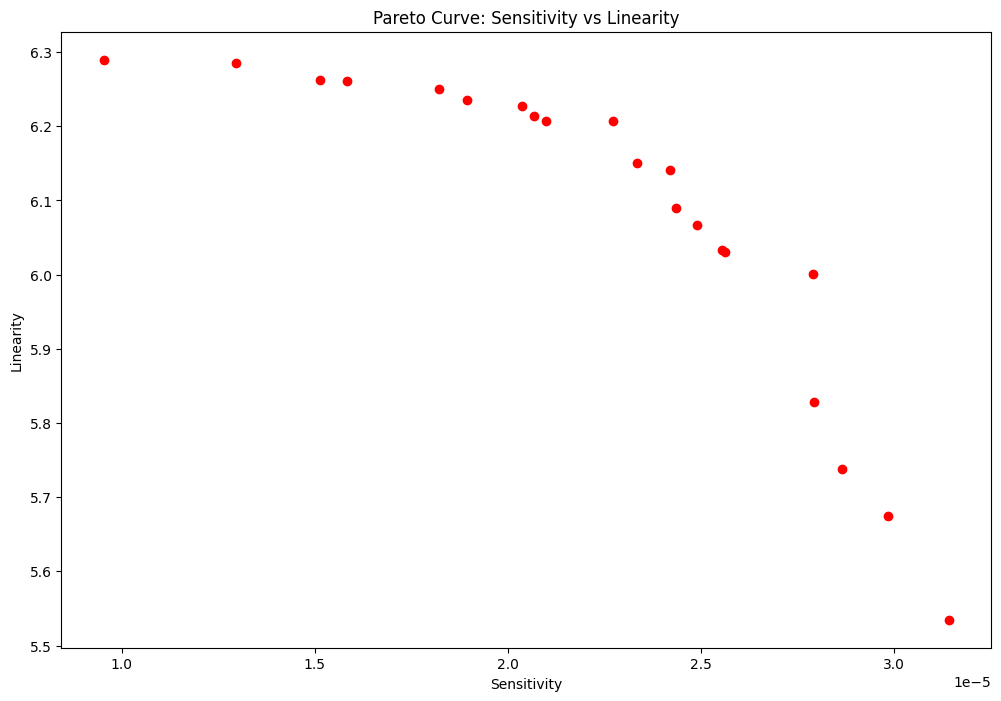

In [182]:
plot(gbest)